In [27]:
from utilities import *
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [2]:
X_train, y_train, X_test, y_test = load_data()

In [3]:
print(X_train.shape)
print(y_train.shape)   
print(np.unique(y_train, return_counts=True))

(1000, 64, 64)
(1000, 1)
(array([0., 1.]), array([500, 500]))


In [4]:
print(X_test.shape)
print(y_test.shape)
print(np.unique(y_test, return_counts=True))

(200, 64, 64)
(200, 1)
(array([0., 1.]), array([100, 100]))


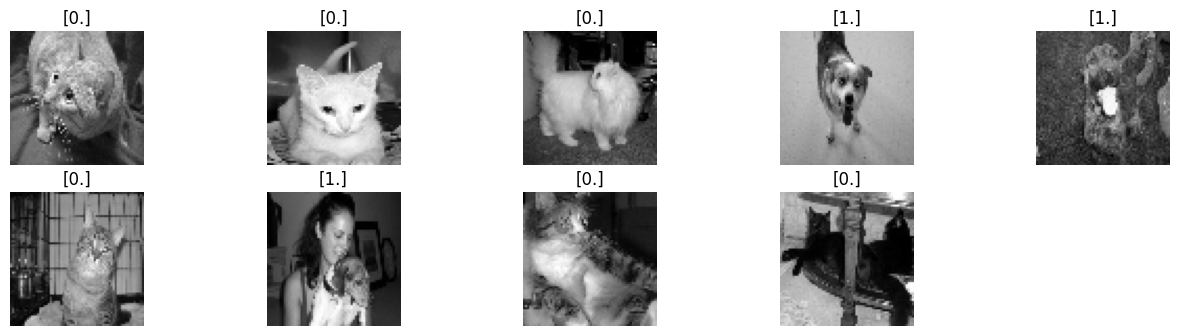

In [5]:
plt.figure(figsize=(16,8))
for i in range(1,10):
    plt.subplot(4,5,i)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(y_train[i])
    plt.axis('off')

plt.show()

In [6]:
# TO DO 
# 1. Normaliser le train_set et le test_set (0-255 -> 0-1)
# 2. flatten() les variables du train_set et du test_set (64x64 -> 4096)
# 3. Entrainer le modele sur le train_set (tracer la courbe d'apprentissage, trouver les bons hyper-params)
# (si vous rencontrez un probleme avec le log_loss, utiliser la fonction de sklearn a la place !)
# 4. Évaluer le modele sur le test_set (tracer également la courbe de Loss pour le test_set)
# 5. Partager vos conclusions dans les commentaires !

In [17]:
# Normalisation et reshape
X_train_reshaped = X_train.reshape(X_train.shape[0], -1) / X_train.max() # X - Xmin / (Xmax - Xmin)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1) / X_train.max() # X - Xmin / (Xmax - Xmin)

In [19]:
X_train_reshaped.shape

(1000, 4096)

In [36]:
class entrainement:
    def __init__(self, X):
        self.W = np.random.randn(X.shape[1],1)
        self.b = np.random.randn(1)
        
    def logit(self, X): # z = W*X + b
        return np.dot(X, self.W) + self.b
    
    def sigmoid_activation(self, z): # A = 1 / (1 + e^(-z))
        return 1 / (1 + np.exp(-z)) 
    
    def loss(self, y, A):  # L = -1/m * sum(y*log(A) + (1-y)*log(1-A))
        epsilon = 1e-5
        return -np.mean(y * np.log(A+epsilon) + (1-y) * np.log(1-A+epsilon)) 
    
    def gradient(self, A, X, y):
        m = len(y)
        dW = 1/m * np.dot(X.T, (A-y))
        db = 1/m * np.sum(A-y)
        return (dW, db)

    def update(self, dW, db, learning_rate):
        self.W -= learning_rate * dW
        self.b -= learning_rate * db
        return (self.W, self.b)
    
    def predict(self, X, W, b):
        A = self.sigmoid_activation(self.logit(X))
        return A>=0.5

    
    def train(self, X, y, learning_rate=0.01, n_iter=10000):
        losses = []
        acc =  []
        for i in tqdm(range(n_iter)):
            z = self.logit(X)
            A = self.sigmoid_activation(z)
            loss = self.loss(y, A)
            dW, db = self.gradient(A, X, y)
            self.update(dW, db, learning_rate)
            if i % 10 ==0:
                losses.append(loss)
                y_pred = self.predict(X, self.W, self.b)
                acc.append(accuracy_score(y, y_pred))
        return losses, acc


100%|██████████| 10000/10000 [04:32<00:00, 36.65it/s]


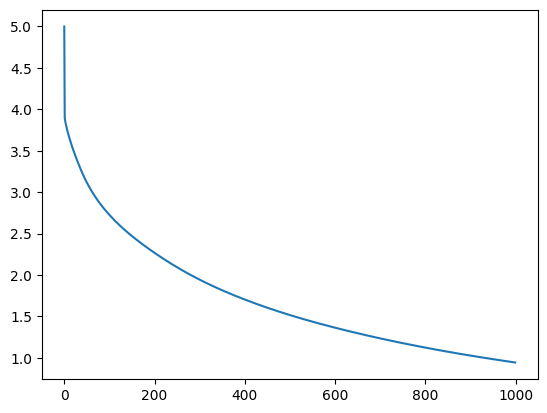

In [37]:
model = entrainement(X_train_reshaped)
losses, acc = model.train(X_train_reshaped, y_train)



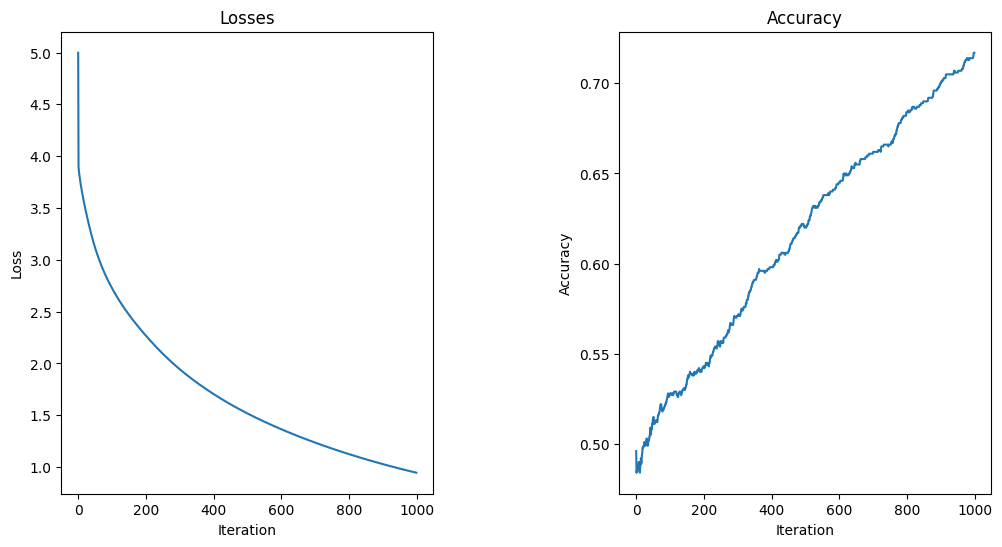

In [52]:
plt.figure(figsize=(12, 6))  

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(acc)
plt.title('Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

plt.subplots_adjust(wspace=0.5)  
